In [1]:
#plotting the Power Law fit with PLFit function, modified
import numpy as np
import yt
import time
from yt.funcs import mylog
import matplotlib.pyplot as plt
mylog.setLevel(40) #prevents warning
plt.style.use('default')
import scipy
from scipy import optimize
from pdf_fitter import *
import pandas as pd
plt.rcParams["font.family"] = "serif"

In [2]:
###all setup condensed to one block. no need to rerun between trials
#only cell in need of changing between runs
inputfile = ('/scratch/jak491/npz_storage/covering_grid_den0.npz','/scratch/jak491/npz_storage/covering_grid_den1.npz','/scratch/jak491/npz_storage/covering_grid_den2.npz', '/scratch/jak491/npz_storage/covering_grid_den3.npz', '/scratch/jak491/npz_storage/covering_grid_den4.npz', '/scratch/jak491/npz_storage/covering_grid_den5.npz', '/scratch/jak491/npz_storage/covering_grid_den_high.npz')
percent = 5
perc = '5'
titles = ('gravity ','turbulence', 'magnetic fields', 'all+ outflows')
slopes =[]
slopes_error = []
sigmas = []
sigmas_error = []
#titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
sigma_limit = 1
slope_limit = 1

#define Linear function 
def linear(x, m, b): 
    return m*x + b    
#define Log Normal function
def lognorm(x,mu,sigma):
    return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))
 
#plot setup
d = {}
variable_name =('density_g','density_gt','density_gtm', 'density_gtmp')
input_file = inputfile[percent]
plot_data = np.load(input_file, allow_pickle=True)

#editting the package to allow small sigma
class Params():
    def __init__(self, root_finding_lower_lim= -15, root_finding_upper_lim=1, root_finding_step_size=0.2, \
                root_finding_max_tries=40, s_cut_off = 10, y_min_cut_off=0, bounds = [(0,1.01,0.3,3),(5,5,5,10)],\
                shrink_data = 4, debug=False, single_bounds=[(.1,.1),(5,5)]):
        
        ''' Parameters: 
        root_finding_lower_lim - This is the lower limit for the root finding range.
        root_finding_upper_lim - This is the upper limit for the root finding range.
        root_finding_step_size - This is the step_size for root finding. Range shrinks by this value after each iteration.
        root_finding_max_tries - This is the maximum number of attempts to make at root_finding.
        s_cut_off - The maximum cut-off for the x values.
        y_min_cut_off - The minimum cut-off for the y-values.
        bounds - The bounds of the parameters (double PL case).
        shrink_data - The number of data points to remove from the edges.
        debug - Flag for printing the parameter values while fitting is ongoing.
        single_bounds - The bounds of the fitted parameters (single PL case).
        '''
        self.root_finding_lower_lim=root_finding_lower_lim
        self.root_finding_upper_lim=root_finding_upper_lim
        self.root_finding_step_size=root_finding_step_size   #This means the range shrinks by 0.2 (default) everytime.
        self.root_finding_max_tries=root_finding_max_tries
        self.s_cut_off=s_cut_off
        self.y_min_cut_off=y_min_cut_off
        self.bounds = bounds
        self.shrink_data = shrink_data                       #Removing some data points from the edges helps to fit better.
        self.debug=debug
        self.single_bounds=single_bounds
        


starting
0
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.5815782221867449 +/- 0.04008378296544002 
 alpha= 2.2480112709962516 +/- 0.028069192013639516 
 s0= -0.330061149779311 +/- 0.009142722187994291 
 st= 0.43029096016335944 +/- 0.28260698018139846
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.26865334554440473 +/- 0.0705666170304148 
 alpha= 2.280963912621077 +/- 0.030053649060569638 
 s0= -0.37177512610192076 +/- 0.03665303360452632 
 st= -0.20714742231009273 +/- 0.12484370110952858
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.5814298491878785 +/- 0.042536971583291776 
 alpha= 2.3448508518530398 +/- 0.03785437473000907 
 s0= -0.304596512531526 +/- 0.01090865783482871 
 st= 0.48810533638602294 +/- 0.303687059066326
1
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.8029344149597988 +/- 0.03207017086907433 
 alpha= 2.3232275250311583 +/- 0.04043028547593753 
 s0= -0.3672307786195974 +/- 0.01

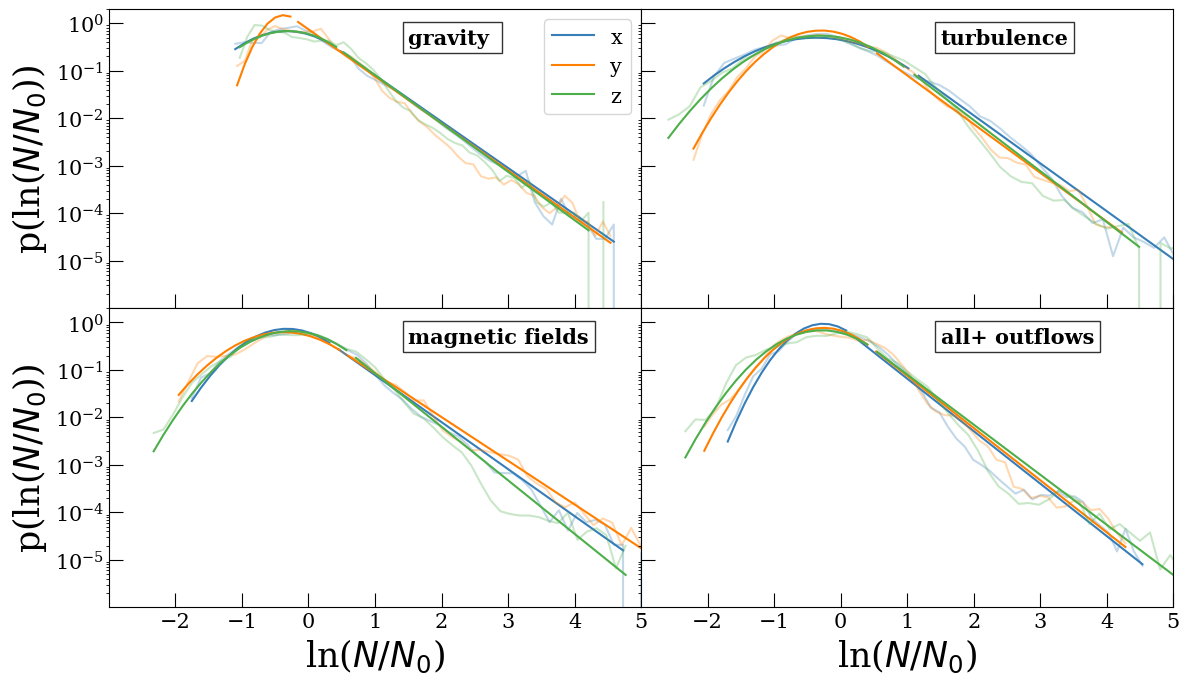

time: 1.360080619653066


In [4]:
#power law fitting. 
start = time.time()
print('starting')
slopes = []
transit =[]
transit_error = []
error = []
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,8), sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})

ax =ax.ravel()
#plt.suptitle('Column Densities with ' + perc + '% SFE', size =26)
#ax[0].annotate(' log upper limit = .75\n linear lower limit = 1',[-2,1e-5], size =15)

ax[0].plot(100,100, color = '#377eb8', alpha =1)
ax[0].plot(100,100, color = '#ff7f00', alpha =1)
ax[0].plot(100,100, color = '#4daf4a', alpha =1)
ax[0].legend([ 'x', 'y', 'z'],fontsize =15)
b = 0

for n in range(4):
    den = plot_data[plot_data.files[n]]
    color_list = ('#377eb8', '#ff7f00', '#4daf4a')
    print(n)     #for time keeping
    
    for a in (range(3)):
        log_den_d = plot_data[plot_data.files[4+b]]
        counts_d, binS_d = np.histogram(log_den_d,bins=50, density= True)
        b = b+1
        
        bin_list = []
        for i in range(len(binS_d)-1):
            bin_i=(binS_d[i]+binS_d[i+1])/2
            bin_list.append(bin_i)

#######################################################################################
        #power fit specifics
        xdata = bin_list
        ydata = counts_d
        #p0= (sigma, alpha)
        p0=[.66, 3]
        params = Params(s_cut_off = 6) #cut off for x, the maximum value of x
        results = PLFit(xdata, ydata, p0, params)#, use_K21=True)
        y_int = .6
        sigma_limit = results.sg
        slope_limit = results.sg
        trans = results.sg
        trans_error = results.sg_err
        transit.append(trans)
        transit_error.append(trans_error)
        slope = results.alpha_g
        slopes.append(slope)
        sigma = results.sigma
        sigmas.append(sigma)
        slope_error = results.alpha_g_err
        slopes_error.append(slope_error)
        sigma_error = results.sigma_err
        sigmas_error.append(sigma_error)
#######################################################################################
        #create subrange and plots linear fit
        x =[]
        y = []
        x_log =[]
        y_log = []
        for i in range(len(bin_list)):
            if bin_list[i] > slope_limit:
                if counts_d[i] > 0:
                        x.append(bin_list[i])
                        y.append(counts_d[i])
                else:
                    break

        #create subrange and plots linear fit
        x =[]
        y = []
        x_log =[]
        y_log = []
        for i in range(len(bin_list)):
            if bin_list[i] > slope_limit:
                if counts_d[i] > 0:
                        x.append(bin_list[i])
                        y.append(counts_d[i])
                else:
                    break
        for i in range(len(bin_list)):
            if bin_list[i] < sigma_limit:
                    x_log.append(bin_list[i])
                    y_log.append(counts_d[i])
            else:
                break
                
        
        log_param, log_con = scipy.optimize.curve_fit(lognorm, x_log, np.log(y_log))
        y_log = lognorm(np.array(x_log),results.s0,results.sigma)
        #find y intercept
        m = -1*results.alpha_g
        x_b = x_log[len(x_log)-1]
        y_b = y_log[len(y_log)-1]
        b_log =  y_b-(m*x_b)
        
        y = linear(np.array(x),m,b_log)

        
        ax[n].plot(x,np.exp(y), color = color_list[a])
        ax[n].plot(x_log,np.exp(y_log), color = color_list[a])

    
        ax[n].plot(bin_list, counts_d, color = color_list[a], alpha = .3)
        #ax[n].plot(x,np.exp(y), color = color_list[a])


        
    if n > 1:
        ax[n].set_xlabel(r'ln($N/N_0$)', size=25)
    if n == 0 or n == 2:
        ax[n].set_ylabel(r'p(ln($N/N_0$))', size=25)
    

    ax[n].annotate(titles[n], (1.5,.5), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))

    #ax[n].set_title(titles[n], size = 17)
    ax[n].tick_params(direction='in', length=6, size = 10, labelsize = 14)
    ax[n].set_yscale('log')
    ax[n].set_ylim(10**(-6),2)
    ax[n].set_xlim(-3,5)
    ax[n].tick_params(direction='in', length=10, labelsize = 15, which = 'major')

    ax[n].set_xticks((-2,-1,0,1,2,3,4,5))
    ax[n].set_yticks((1e0,1e-1,1e-2,1e-3,1e-4,1e-5))

plt.tight_layout()
plt.subplots_adjust(top=.85)
plt.savefig('PLFit_column_lim,75_4lv_'+perc+'%.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

file = open("txt_file_storage/power_fit_slope" +perc+"%.txt", "w")
str_dictionary = repr(slopes)
file.write(str_dictionary + "\n")
str_dictionary = repr(slopes_error)
file.write(str_dictionary + "\n")
file.close()

file = open("txt_file_storage/power_fit_sigma" +perc+"%.txt", "w")
str_dictionary = repr(sigmas)
file.write(str_dictionary + "\n")
str_dictionary = repr(sigmas_error)
file.write(str_dictionary + "\n")
file.close()

file = open("txt_file_storage/trans_density" +perc+"%.txt", "w")
str_dictionary = repr(transit)
file.write(str_dictionary + "\n")
str_dictionary = repr(transit_error)
file.write(str_dictionary + "\n")
file.close()

end = time.time()
print("time:",(end-start)/60)

In [ ]:
np.exp(y_log[len(y_log)-1])

In [ ]:
(x_log[len(y_log)-1])

In [56]:
b_log

1.3118747662622012

starting
0
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.10000000000000307 +/- 0.10928248321876056 
 alpha= 2.6408532210778017 +/- 0.03059165207226447 
 s0= -0.37561331543520693 +/- 0.10095095020895145 
 st= -0.3492047832244273 +/- 0.10823808534416399
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.20861667327218772 +/- 0.06454079173797454 
 alpha= 2.9880822946132644 +/- 0.04598161138232658 
 s0= -0.24580656492930664 +/- 0.03470328829472657 
 st= -0.11576248528726699 +/- 0.10803838091627109
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.40156356349768735 +/- 0.031179610878300845 
 alpha= 3.2848939812394335 +/- 0.06130549228855698 
 s0= -0.1574463545135114 +/- 0.003989879345553949 
 st= 0.37225362542459683 +/- 0.20901082881908306
1
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.7529325081606142 +/- 0.018945738943891583 
 alpha= 2.9664740488897703 +/- 0.08621811521212078 
 s0= -0.2675185444603538 

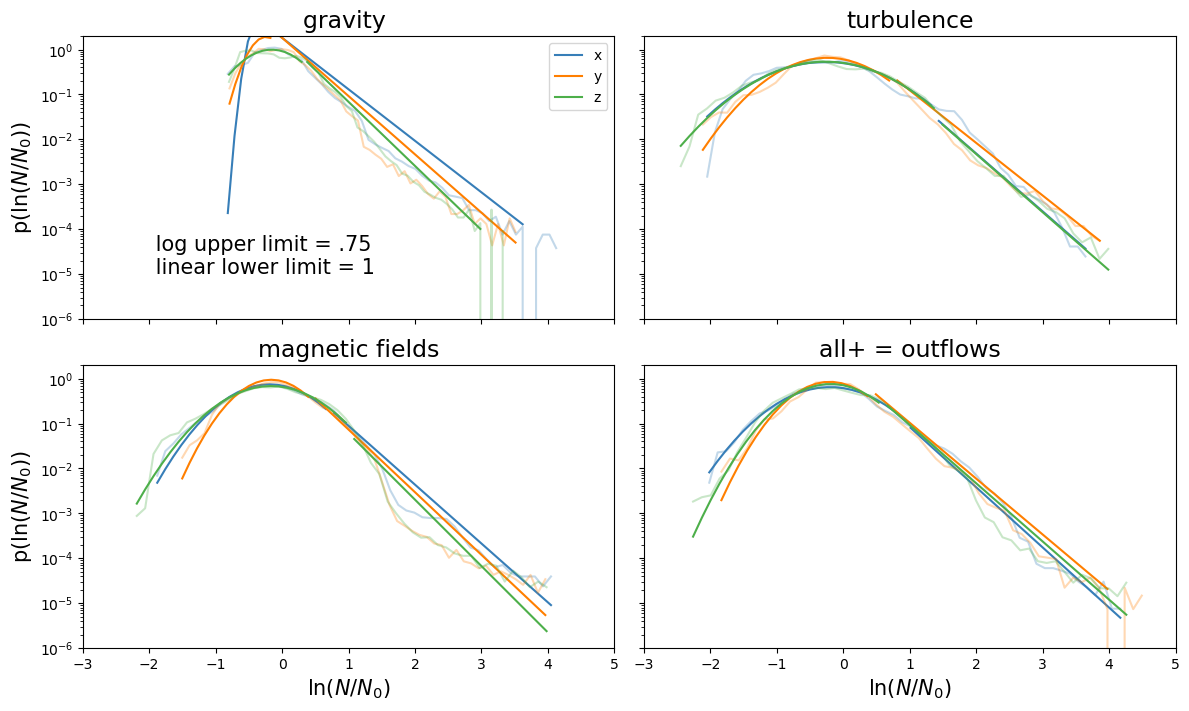

0
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.36244014123986146 +/- 0.05638888412172225 
 alpha= 2.7885857816600343 +/- 0.041161972177574474 
 s0= -0.22788515364780795 +/- 0.009546808102856116 
 st= 0.13843143878177042 +/- 0.20463284179109245
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.3087122601903729 +/- 0.052245084441204036 
 alpha= 3.19851238182793 +/- 0.06137436906345061 
 s0= -0.18288588793487515 +/- 0.011410358989656755 
 st= 0.12194276789821373 +/- 0.17780695535360108
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.42593859242792903 +/- 0.03932547845408062 
 alpha= 3.3776163140040665 +/- 0.08294954601246497 
 s0= -0.1472593594579939 +/- 0.006605443381966159 
 st= 0.4655202371217471 +/- 0.26383175485736127
1
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.8275849029453891 +/- 0.02458333103911608 
 alpha= 2.8210806727083164 +/- 0.06507738760721685 
 s0= -0.32135880269877415 +/- 0.01824

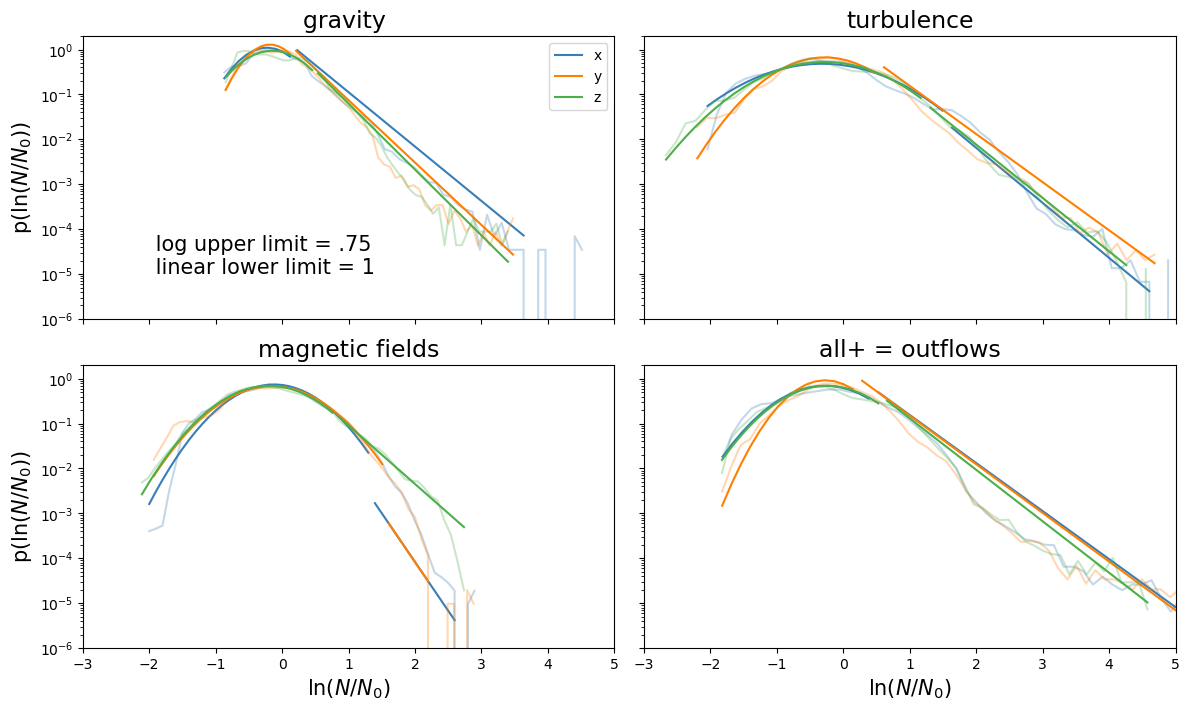

0
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.42694917260299803 +/- 0.04266239791117518 
 alpha= 2.820015690810339 +/- 0.04598553400662741 
 s0= -0.21320032868292207 +/- 0.0047095350306027555 
 st= 0.3008479122073967 +/- 0.23000285073910873
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.3997917113183916 +/- 0.03028541470623355 
 alpha= 3.4092119844576954 +/- 0.06843065134286883 
 s0= -0.14575188030895475 +/- 0.004154771967305618 
 st= 0.3991541048944724 +/- 0.2124203998526155
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.48907333337902575 +/- 0.02799944509876531 
 alpha= 3.479436705983242 +/- 0.08249329481563492 
 s0= -0.14213776352660865 +/- 0.008493738945374285 
 st= 0.6901181851125101 +/- 0.28243565477670174
1
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.8039314000562957 +/- 0.020652587487253463 
 alpha= 2.40080382286049 +/- 0.03634133421114084 
 s0= -0.3533924028905634 +/- 0.0131298670

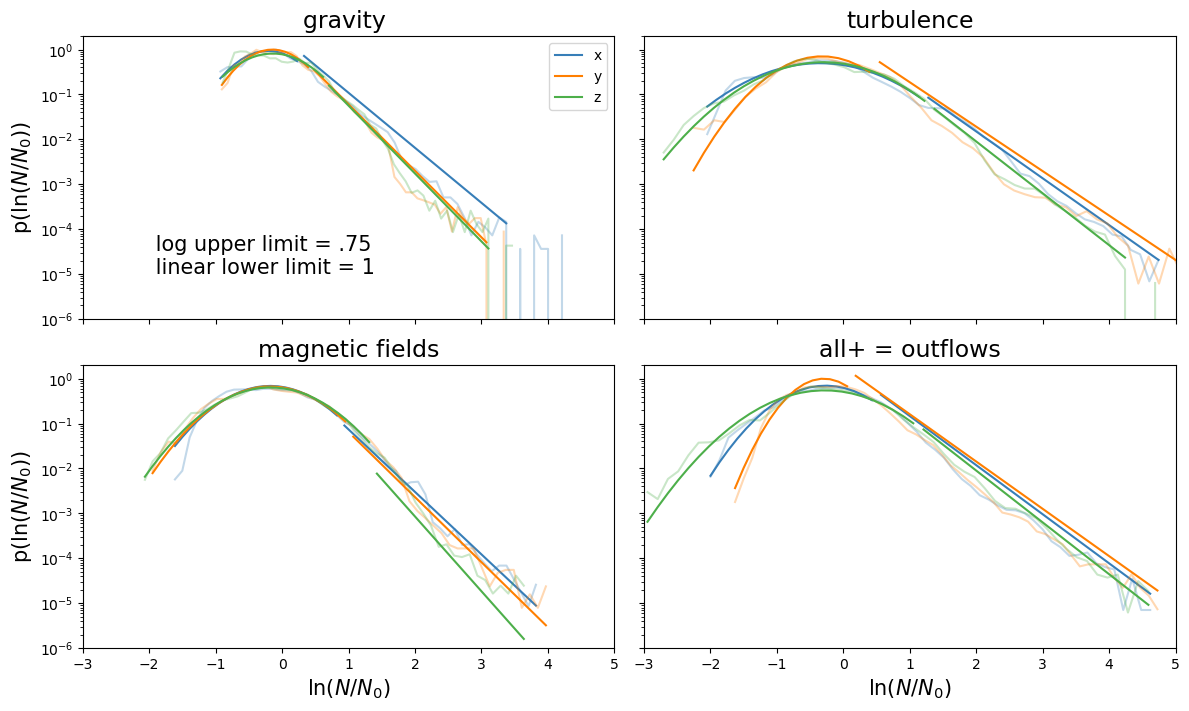

0
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.518554106010303 +/- 0.030962950901327276 
 alpha= 2.8351736585012834 +/- 0.04847984173892252 
 s0= -0.20925837009610998 +/- 0.007774073526352545 
 st= 0.5531151794287446 +/- 0.2638921677109297
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.4996937383261908 +/- 0.015150146196000264 
 alpha= 3.5640002745462223 +/- 0.06507360377356398 
 s0= -0.1381844667719745 +/- 0.005162406112072423 
 st= 0.7517244194647704 +/- 0.21979984755982282
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.5969217432347679 +/- 0.010635335478858754 
 alpha= 3.693979743355203 +/- 0.05207060800302437 
 s0= -0.16118396223093387 +/- 0.005458517687380749 
 st= 1.1550385265277066 +/- 0.24921425348562093
1
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.8054159214852933 +/- 0.027342448647487947 
 alpha= 2.4376548546889363 +/- 0.05033030059381028 
 s0= -0.34806351862238505 +/- 0.01764938

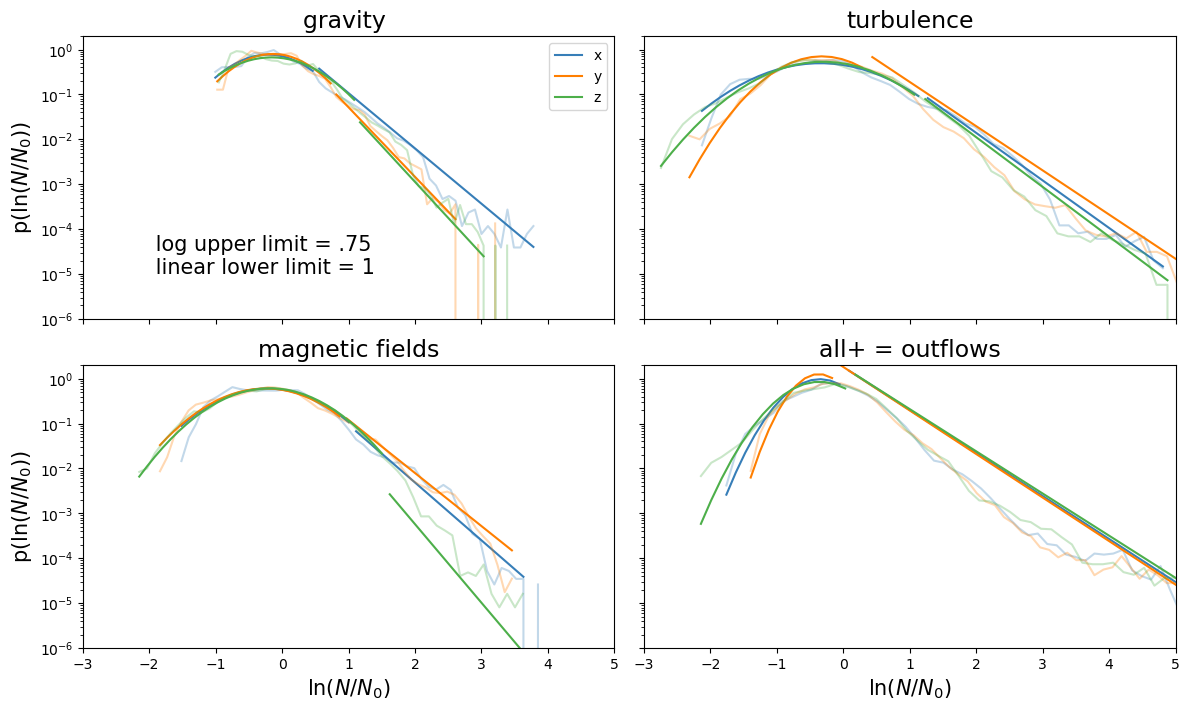

0
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.5236498255739984 +/- 0.03066162242268003 
 alpha= 2.373795620706625 +/- 0.032020107997089306 
 s0= -0.29516305615946414 +/- 0.006295034011443032 
 st= 0.35575339911171555 +/- 0.22301164794480124
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.457792922965578 +/- 0.029049450122260193 
 alpha= 2.688682262160989 +/- 0.03279253752426926 
 s0= -0.2322929740604848 +/- 0.004066396989612936 
 st= 0.33118589112855734 +/- 0.20089559287897282
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.6269291158272983 +/- 0.017726472938294588 
 alpha= 2.816416860730983 +/- 0.03922025837277397 
 s0= -0.2291403356769876 +/- 0.007798367789438045 
 st= 0.8778244747351336 +/- 0.26380557264514615
1
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.7984588952057046 +/- 0.0277151426767844 
 alpha= 2.3813704405311458 +/- 0.042638495908155744 
 s0= -0.35424287492203693 +/- 0.017207194

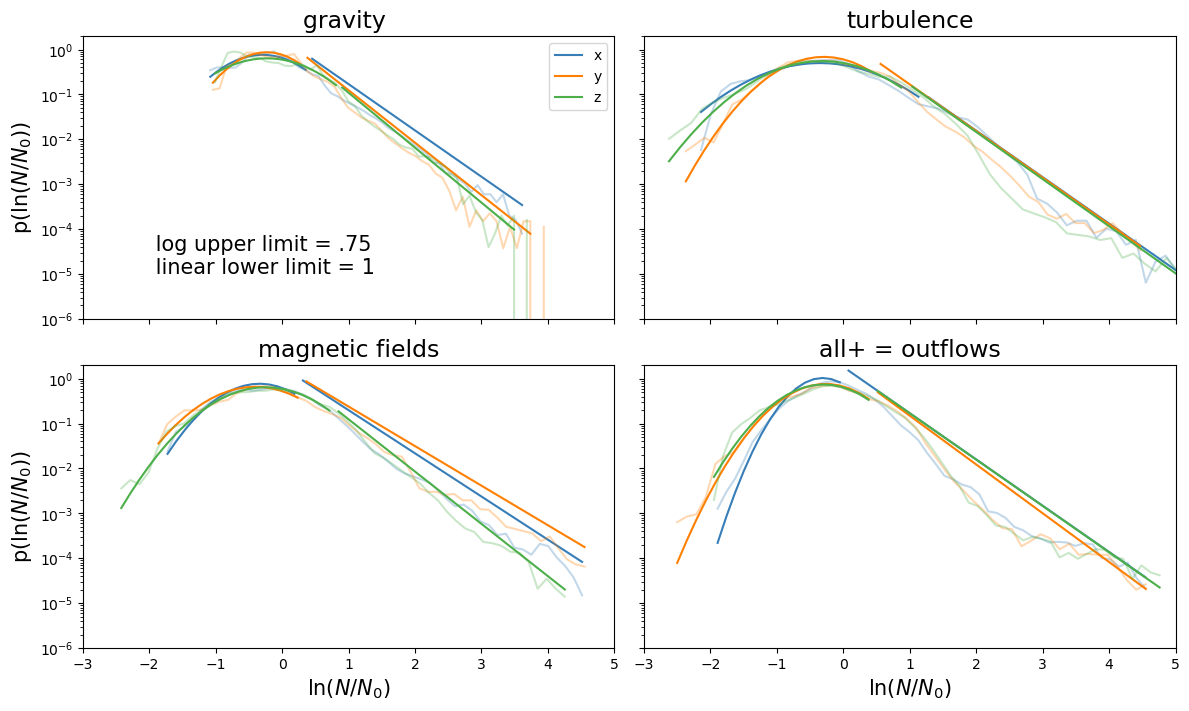

0
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.5815688083158896 +/- 0.040085572091387245 
 alpha= 2.2480060515210156 +/- 0.028070706855036112 
 s0= -0.3300619896947734 +/- 0.009142593890060644 
 st= 0.4302637398202618 +/- 0.2826057744885753
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.26865334554440473 +/- 0.0705666170304148 
 alpha= 2.280963912621077 +/- 0.030053649060569638 
 s0= -0.37177512610192076 +/- 0.03665303360452632 
 st= -0.20714742231009273 +/- 0.12484370110952858
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.5814338394185903 +/- 0.04253704082237135 
 alpha= 2.344852419145228 +/- 0.037855829826247876 
 s0= -0.3045964581493314 +/- 0.010909048543599786 
 st= 0.48811680094465176 +/- 0.3036906666327345
1
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.8029430428010943 +/- 0.03207072680294458 
 alpha= 2.3232316771047197 +/- 0.040429897742487154 
 s0= -0.3672337979637484 +/- 0.01960860

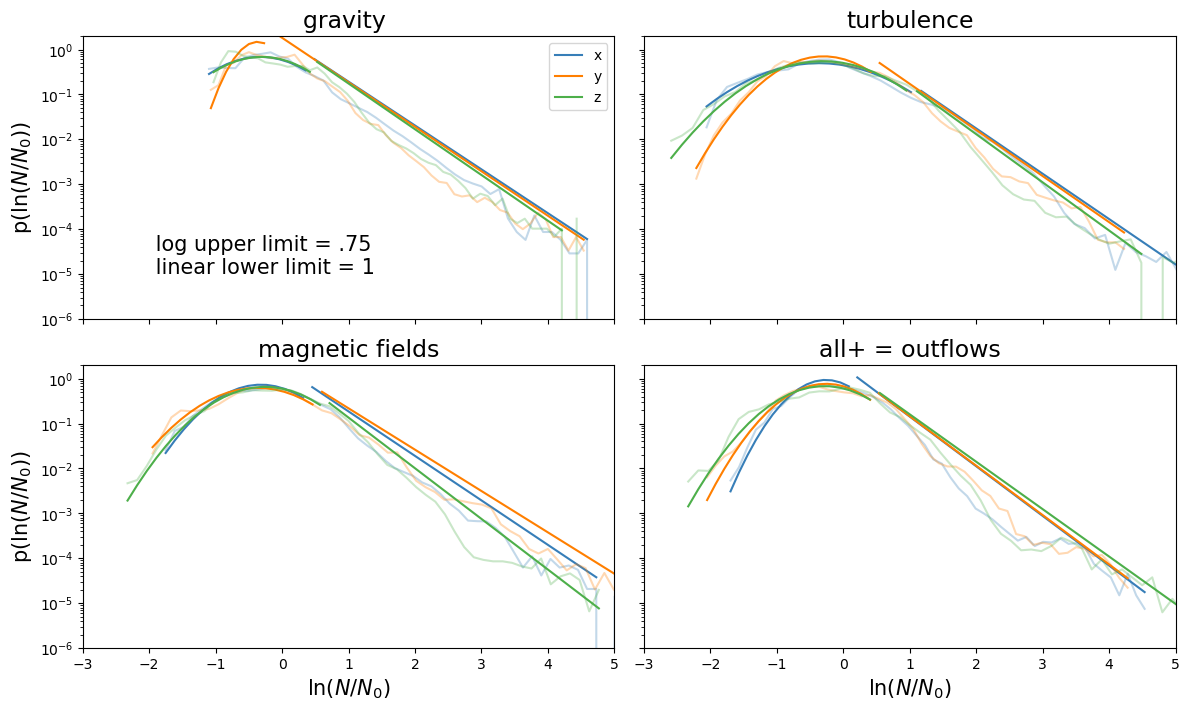

time: 5.72584890127182


In [13]:
pp = ('0','1','2','3','4','5')
start = time.time()
print('starting')
for p in range(6):
    ###master cell for full run
    inputfile = ('/scratch/jak491/npz_storage/covering_grid_den0.npz','/scratch/jak491/npz_storage/covering_grid_den1.npz','/scratch/jak491/npz_storage/covering_grid_den2.npz', '/scratch/jak491/npz_storage/covering_grid_den3.npz', '/scratch/jak491/npz_storage/covering_grid_den4.npz', '/scratch/jak491/npz_storage/covering_grid_den5.npz', '/scratch/jak491/npz_storage/covering_grid_den_high.npz')
    percent = p
    perc = pp[p]
    titles = ('gravity ','turbulence', 'magnetic fields', 'all+ = outflows')
    slopes =[]
    slopes_error = []
    sigmas = []
    sigmas_error = []
    transit =[]
    transit_error=[]
    #titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
    sigma_limit = 1
    slope_limit = 1

    #define Linear function 
    def linear(x, m, b): 
        return m*x + b    
    #define Log Normal function
    def lognorm(x,mu,sigma):
        return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))

    #plot setup
    d = {}
    variable_name =('density_g','density_gt','density_gtm', 'density_gtmp')
    input_file = inputfile[percent]
    plot_data = np.load(input_file, allow_pickle=True)

    #editting the package to allow small sigma
    class Params():
        def __init__(self, root_finding_lower_lim= -15, root_finding_upper_lim=1, root_finding_step_size=0.2, \
                    root_finding_max_tries=40, s_cut_off = 10, y_min_cut_off=0, bounds = [(0,1.01,0.3,3),(5,5,5,10)],\
                    shrink_data = 4, debug=False, single_bounds=[(.1,.1),(5,5)]):

            ''' Parameters: 
            root_finding_lower_lim - This is the lower limit for the root finding range.
            root_finding_upper_lim - This is the upper limit for the root finding range.
            root_finding_step_size - This is the step_size for root finding. Range shrinks by this value after each iteration.
            root_finding_max_tries - This is the maximum number of attempts to make at root_finding.
            s_cut_off - The maximum cut-off for the x values.
            y_min_cut_off - The minimum cut-off for the y-values.
            bounds - The bounds of the parameters (double PL case).
            shrink_data - The number of data points to remove from the edges.
            debug - Flag for printing the parameter values while fitting is ongoing.
            single_bounds - The bounds of the fitted parameters (single PL case).
            '''
            self.root_finding_lower_lim=root_finding_lower_lim
            self.root_finding_upper_lim=root_finding_upper_lim
            self.root_finding_step_size=root_finding_step_size   #This means the range shrinks by 0.2 (default) everytime.
            self.root_finding_max_tries=root_finding_max_tries
            self.s_cut_off=s_cut_off
            self.y_min_cut_off=y_min_cut_off
            self.bounds = bounds
            self.shrink_data = shrink_data                       #Removing some data points from the edges helps to fit better.
            self.debug=debug
            self.single_bounds=single_bounds


    #power law fitting. 

    slopes = []

    error = []
    fig, ax = plt.subplots(nrows=2,ncols=2, sharex=True, sharey=True,figsize=(12,8))
    ax =ax.ravel()
    #plt.suptitle('Column Densities with ' + perc + '% SFE', size =26)
    ax[0].annotate(' log upper limit = .75\n linear lower limit = 1',[-2,1e-5], size =15)

    ax[0].plot(100,100, color = '#377eb8', alpha =1)
    ax[0].plot(100,100, color = '#ff7f00', alpha =1)
    ax[0].plot(100,100, color = '#4daf4a', alpha =1)
    ax[0].legend([ 'x', 'y', 'z'])
    b = 0

    for n in range(4):
        den = plot_data[plot_data.files[n]]
        color_list = ('#377eb8', '#ff7f00', '#4daf4a')
        print(n)     #for time keeping

        for a in (range(3)):
            log_den_d = plot_data[plot_data.files[4+b]]
            counts_d, binS_d = np.histogram(log_den_d,bins=50, density= True)
            b = b+1

            bin_list = []
            for i in range(len(binS_d)-1):
                bin_i=(binS_d[i]+binS_d[i+1])/2
                bin_list.append(bin_i)

    #######################################################################################
            #power fit specifics
            xdata = bin_list
            ydata = counts_d
            #p0= (sigma, alpha)
            p0=[.66, 3]
            params = Params(s_cut_off = 6) #cut off for x, the maximum value of x
            results = PLFit(xdata, ydata, p0, params)#, use_K21=True)
            y_int = .6
            sigma_limit = results.sg
            slope_limit = results.sg
            trans = results.sg
            trans_error = results.sg_err
            transit.append(trans)
            transit_error.append(trans_error)
            slope = results.alpha_g
            slopes.append(slope)
            sigma = results.sigma
            sigmas.append(sigma)
            slope_error = results.alpha_g_err
            slopes_error.append(slope_error)
            sigma_error = results.sigma_err
            sigmas_error.append(sigma_error)
    #######################################################################################
            #create subrange and plots linear fit
            x =[]
            y = []
            x_log =[]
            y_log = []
            for i in range(len(bin_list)):
                if bin_list[i] > slope_limit:
                    if counts_d[i] > 0:
                            x.append(bin_list[i])
                            y.append(counts_d[i])
                    else:
                        break

            #create subrange and plots linear fit
            x =[]
            y = []
            x_log =[]
            y_log = []
            for i in range(len(bin_list)):
                if bin_list[i] > slope_limit:
                    if counts_d[i] > 0:
                            x.append(bin_list[i])
                            y.append(counts_d[i])
                    else:
                        break
            for i in range(len(bin_list)):
                if bin_list[i] < sigma_limit:
                        x_log.append(bin_list[i])
                        y_log.append(counts_d[i])
                else:
                    break

            y = linear(np.array(x),-1*results.alpha_g,y_int)

            log_param, log_con = scipy.optimize.curve_fit(lognorm, x_log, np.log(y_log))
            y_log = lognorm(np.array(x_log),results.s0,results.sigma)


            ax[n].plot(x,np.exp(y), color = color_list[a])
            ax[n].plot(x_log,np.exp(y_log), color = color_list[a])


            ax[n].plot(bin_list, counts_d, color = color_list[a], alpha = .3)
            #ax[n].plot(x,np.exp(y), color = color_list[a])



        if n > 1:
            ax[n].set_xlabel(r'ln($N/N_0$)', size=15)
        if n == 0 or n == 2:
            ax[n].set_ylabel(r'p(ln($N/N_0$))', size=15)



        ax[n].set_title(titles[n], size = 17)
        ax[n].set_yscale('log')
        ax[n].set_ylim(10**(-6),2)
        ax[n].set_xlim(-3,5)

    plt.tight_layout()
    plt.subplots_adjust(top=.85)
    plt.savefig('PLFit_column_lim,75_4lv_'+perc+'%', bbox_inches='tight')
    plt.show()

    file = open("txt_file_storage/power_fit_slope" +perc+"%.txt", "w")
    str_dictionary = repr(slopes)
    file.write(str_dictionary + "\n")
    str_dictionary = repr(slopes_error)
    file.write(str_dictionary + "\n")
    file.close()

    file = open("txt_file_storage/power_fit_sigma" +perc+"%.txt", "w")
    str_dictionary = repr(sigmas)
    file.write(str_dictionary + "\n")
    str_dictionary = repr(sigmas_error)
    file.write(str_dictionary + "\n")
    file.close()

    file = open("txt_file_storage/trans_density" +perc+"%.txt", "w")
    str_dictionary = repr(transit)
    file.write(str_dictionary + "\n")
    str_dictionary = repr(transit_error)
    file.write(str_dictionary + "\n")
end = time.time()
print("time:",(end-start)/60)

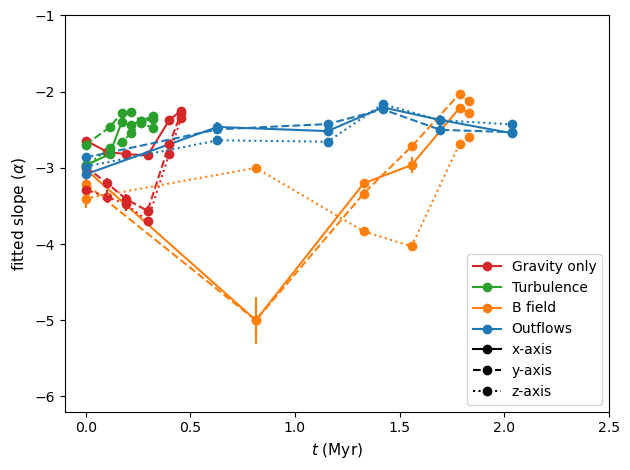

In [49]:
#importing timing and other files
def convert(slope):
    return [-i for i in slope]
inputfile = ('slope_0%.txt','slope_1%.txt','slope_2%.txt','slope_3%.txt','slope_4%.txt','slope_5%.txt')#,'slope_10%_and_6%.txt',)
time_file = pd.read_csv("Time_conversions.csv")
times = time_file['time']
times = times*3.71e-14   #convert seconds to Myear
time_gtmp =times[0:6]
time_gtmp = time_gtmp-time_gtmp[0]
time_gtm = times[7:13]
time_gtm = time_gtm-time_gtm[7]
time_gt = times[14:20]
time_gt = time_gt-time_gt[14]
time_g = times[21:27]
time_g = time_g-time_g[21]

#main plotting cell
line = ('solid', 'dashed', 'dotted')
#inputfile = ('txt_file_storage/slope_0%_lim,5.txt','txt_file_storage/slope_1%_lim,5.txt','txt_file_storage/slope_2%_lim,5.txt','txt_file_storage/slope_3%_lim,5.txt','txt_file_storage/slope_4%_lim,5.txt','txt_file_storage/slope_5%_lim,5.txt')#,'slope_10%_and_6%.txt',)
inputfile = ('txt_file_storage/power_fit_slope0%.txt','txt_file_storage/power_fit_slope1%.txt','txt_file_storage/power_fit_slope2%.txt','txt_file_storage/power_fit_slope3%.txt','txt_file_storage/power_fit_slope4%.txt','txt_file_storage/power_fit_slope5%.txt')

for a in range(3):
    slope_x_g = []
    slope_x_gt = []
    slope_x_gtm = []
    slope_x_gtmp = []
    error_x_g = []
    error_x_gt = []
    error_x_gtm = []
    error_x_gtmp = []
    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        slope_x_g.append(slope_list[0+a])
        slope_x_gt.append(slope_list[3+a])
        slope_x_gtm.append(slope_list[6+a])
        slope_x_gtmp.append(slope_list[9+a])
        #error bar cutting
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[1]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        error_x_g.append(slope_list[0+a])
        error_x_gt.append(slope_list[3+a])
        error_x_gtm.append(slope_list[6+a])
        error_x_gtmp.append(slope_list[9+a])
        
    plt.errorbar(time_g,convert(slope_x_g),yerr = error_x_g, marker = "o", color = 'C3', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gt,convert(slope_x_gt),yerr = error_x_gt, marker = "o", color = 'C2', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gtm,convert(slope_x_gtm),yerr = error_x_gtm, marker = "o", color = 'C1', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gtmp,convert(slope_x_gtmp),yerr = error_x_gtmp, marker = "o", color = 'C0', linestyle = line[a])#, alpha =alpha[a])
    #Invisible lines to fix legend
    plt.plot(0,0, marker = "o", color = 'C3', linestyle = line[0])
    plt.plot(0,0, marker = "o", color = 'C2', linestyle = line[0])
    plt.plot(0,0, marker = "o", color = 'C1', linestyle = line[0])
    plt.plot(0,0, marker = "o", color = 'C0', linestyle = line[0])
    plt.plot(0,0, marker = "o", color = 'black', linestyle = line[0])
    plt.plot(0,0, marker = "o", color = 'black', linestyle = line[1])
    plt.plot(0,0, marker = "o", color = 'black', linestyle = line[2])
    #plot bells and whistles
    #plt.title('Fitted Slope V.S. time', size = 15)
    plt.xlabel(r'$t$ (Myr)', size=11)
    plt.ylabel(r'fitted slope ($\alpha$)', size=11)
    plt.ylim(-6.2,-1)
    plt.xlim(-.1,2.5)
    plt.legend(['Gravity only', 'Turbulence', 'B field', 'Outflows', 'x-axis','y-axis','z-axis'])
    plt.tight_layout()
#plt.plot((0,1,2),(-2,-2,-2), color='black')
plt.savefig('pdfit_slope_plot_lim1')



/home/jak491/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


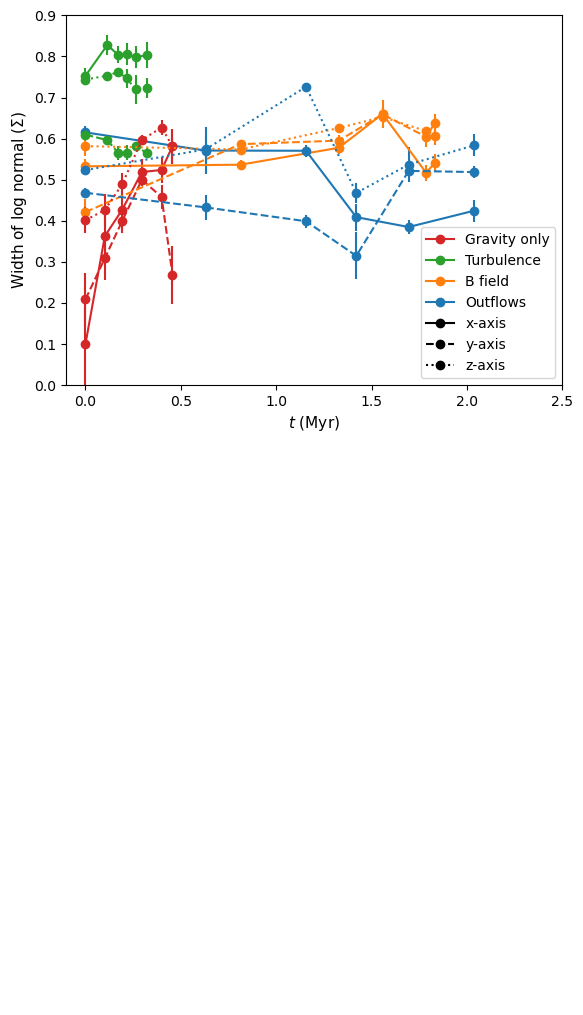

In [50]:
#importing timing and other files
def convert(slope):
    return [-i for i in slope_x_g]
inputfile = ('slope_0%.txt','slope_1%.txt','slope_2%.txt','slope_3%.txt','slope_4%.txt','slope_5%.txt')#,'slope_10%_and_6%.txt',)
time_file = pd.read_csv("Time_conversions.csv")
times = time_file['time']
times = times*3.71e-14   #convert seconds to Myear
time_gtmp =times[0:6]
time_gtmp = time_gtmp-time_gtmp[0]
time_gtm = times[7:13]
time_gtm = time_gtm-time_gtm[7]
time_gt = times[14:20]
time_gt = time_gt-time_gt[14]
time_g = times[21:27]
time_g = time_g-time_g[21]

#main plotting cell
line = ('solid', 'dashed', 'dotted')
#inputfile = ('txt_file_storage/slope_0%_lim,5.txt','txt_file_storage/slope_1%_lim,5.txt','txt_file_storage/slope_2%_lim,5.txt','txt_file_storage/slope_3%_lim,5.txt','txt_file_storage/slope_4%_lim,5.txt','txt_file_storage/slope_5%_lim,5.txt')#,'slope_10%_and_6%.txt',)
inputfile = ('txt_file_storage/power_fit_sigma0%.txt','txt_file_storage/power_fit_sigma1%.txt','txt_file_storage/power_fit_sigma2%.txt','txt_file_storage/power_fit_sigma3%.txt','txt_file_storage/power_fit_sigma4%.txt','txt_file_storage/power_fit_sigma5%.txt')

plt.annotate('lower limit = 1',[.01,-1.5], size =15)

for a in range(3):
    sigma_x_g = []
    sigma_x_gt = []
    sigma_x_gtm = []
    sigma_x_gtmp = []
    error_x_g = []
    error_x_gt = []
    error_x_gtm = []
    error_x_gtmp = []
    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        sigma_list = string3.astype('float')
        sigma_x_g.append(sigma_list[0+a])
        sigma_x_gt.append(sigma_list[3+a])
        sigma_x_gtm.append(sigma_list[6+a])
        sigma_x_gtmp.append(sigma_list[9+a])
        #error bar cutting
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[1]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        err_list = string3.astype('float')
        error_x_g.append(err_list[0+a])
        error_x_gt.append(err_list[3+a])
        error_x_gtm.append(err_list[6+a])
        error_x_gtmp.append(err_list[9+a])
        
    plt.errorbar(time_g,sigma_x_g,yerr = error_x_g, marker = "o", color = 'C3', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gt,sigma_x_gt,yerr = error_x_gt, marker = "o", color = 'C2', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gtm,sigma_x_gtm,yerr = error_x_gtm, marker = "o", color = 'C1', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gtmp,sigma_x_gtmp,yerr = error_x_gtmp, marker = "o", color = 'C0', linestyle = line[a])#, alpha =alpha[a])
    #Invisible lines to fix legend
    plt.plot(10,0, marker = "o", color = 'C3', linestyle = line[0])
    plt.plot(10,0, marker = "o", color = 'C2', linestyle = line[0])
    plt.plot(10,0, marker = "o", color = 'C1', linestyle = line[0])
    plt.plot(10,0, marker = "o", color = 'C0', linestyle = line[0])
    plt.plot(10,0, marker = "o", color = 'black', linestyle = line[0])
    plt.plot(10,0, marker = "o", color = 'black', linestyle = line[1])
    plt.plot(10,0, marker = "o", color = 'black', linestyle = line[2])
    #plot bells and whistles
    #plt.title('Fitted Slope V.S. time', size = 15)
    plt.xlabel(r'$t$ (Myr)', size=11)
    plt.ylabel(r'Width of log normal ($\Sigma$)', size=11)
    plt.ylim(0,.9)
    plt.xlim(-.1,2.5)
    plt.legend(['Gravity only', 'Turbulence', 'B field', 'Outflows', 'x-axis','y-axis','z-axis'])
    plt.tight_layout()
#plt.plot((0,1,2),(-2,-2,-2), color='black')
plt.savefig('pdfit_sigma_plot_lim1')



In [6]:
result.st

NameError: name 'result' is not defined